# DPHPC Pipeline

### Setup

Please make sure the following packages are installed:
- numpy
- pandas
- matplotlib
- seaborn
- tqdm

If you are using conda, you can create an environment using

```conda env create -f pipeline_env.yml```

```conda activate dphpc```

### Settings

In [1]:
# Settings - Please uncomment the preset for the algorithm you want to benchmark

# Folder where graphs are exported to
OUTPUT_FOLDER = "../../dphpc-report/graphs/pipeline"

# Graphs
COLOR_PALETTE = "husl" #"winter_r"

LINE_WIDTH = 3.28804
ASPECT_RATIO = 4/2
FIGURE_SIZE = (LINE_WIDTH*1.2,LINE_WIDTH*1.2/ASPECT_RATIO)

ERROR_STYLE = {'capsize':3, 'capthick':1, 'elinewidth':1}

TITLE_Y_OFFSET = 1.07

# Replace binary names (left) in graphs with meaningfull name (right). Make sure meaninfull names are unique
DISPLAY_NAME_MAPPING = {
    "cholesky-mpi-ll-naive"             : "MPIC",
    "cholesky-mpi-ll-optimised"         : "mpi-ll-optimised",
    "cholesky-openmp-ll-naive"          : "OMPC",
    "cholesky-openmp-simd-ll-naive"     : "OMPSIMDC",
    "cholesky-mpi-openmp-ll-naive"      : "MPIOMPC",
    "cholesky-blocked-mpi"              : "MPIBC",
    "cholesky-blocked-mpi-old"          : "blocked-mpi-old" ,
    "cholesky-mpi-test"                 : "mpi-test"  ,
    "cholesky-mpi-ll-improved"          : "CMPIC" ,
    "classical-gram-mpi"                : "ICGS (MPI)" ,
    "classical-gram-omp"                : "ICGS (OpenMP)",
    "classical-gram-optimized-simd"     : "ICGS (SIMD)",
    "blocking-gram-mpi"                 : "B2GS",
    "polybench-openmp-gramschmidt"      : "polybench-openmp-gramschmidt",
    "parallel-gramschmidt"              : "parallel",
    "cholesky"                          : "cholesky", 
    "cholesky-simd"                     : "cholesky-simd",
    "gramschmidt"                       : "gramschmidt",
    "gramschmidt-mpi"                   : "gramschmidt-mpi",
    "polybench-mpi-gramschmidt-splitr"  : "PMPI",
    "polybench-mpi-gramschmidt"         : "polybench-mpi-gramschmidt",
    "polybench-mpi-gramschmidt-splitr-optimized" : "PMPIO",
}


# Mapping between baseline and parallel binaries used for benchmarking
# These must match the binary name used in the benchmark folder structure (ie "{date}_{time}-{binary name}" 
BASELINE_MAPPING = { 
    "cholesky-mpi-ll-naive"         : "cholesky", 
    "cholesky-mpi-ll-optimised"     : "cholesky", 
    "cholesky-openmp-ll-naive"      : "cholesky",
    "cholesky-openmp-simd-ll-naive" : "cholesky-simd",
    "cholesky-mpi-openmp-ll-naive"  : "cholesky",
    "cholesky-blocked-mpi"          : "cholesky",
    "cholesky-blocked-mpi-old"      : "cholesky",
    "cholesky-mpi-test"             : "cholesky",
    "cholesky-mpi-ll-improved"      : "cholesky",
    "classical-gram-mpi"            : "gramschmidt",
    "classical-gram-omp"            : "gramschmidt",
    "classical-gram-optimized"      : "gramschmidt",
    "blocking-gram-mpi"             : "gramschmidt",
    "polybench-openmp-gramschmidt"  : "gramschmidt",
    "parallel-gramschmidt"          : "gramschmidt",
    "polybench-mpi-gramschmidt-splitr" : "gramschmidt",
    "polybench-mpi-gramschmidt-splitr-optimized" : "gramschmidt",
}

CACHEGRIND_MAPPING = {
    "sequential_qr_split_gramschmidt"   : ["kernel_gramschmidt", "compute_r_grams", "compute_q_grams", "normalize", "projection", "inner_product"],
    "polybench_parallel_gramschmidt"    : ["kernel_gramschmidt"],
    "polybench_openmp_gramschmidt"      : ["kernel_gramschmidt"],
    "polybench_mpi_gramschmidt"         : ["kernel_gramschmidt", "partial_gramschmidt"],
    "polybench_mpi_gramschmidt_splitr"  : ["kernel_gramschmidt", "partial_gramschmidt"],
    "modified_gram"                     : ["b2gs", "mgs2b", "create_r"],
    "gramschmidt"                       : ["kernel_gramschmidt"],
    "classical_gram"                    : ["icgs"],
    "classical_gram_optimized"          : ["icgs"],
    "classical_gram_optimized_simd"     : ["icgs"],
    "classical_gram_omp"                : ["icgs"],
    "classical_gram_omp_ref"            : ["icgs"],
    "classical_gram_mpi"                : ["icgs", "wrapper_icgs"],
    "blocking_gram_mpi"                 : ["b2gs_wrapper", "b2gs_mpi", "create_partial_r", "mgs2b_mpi"],
    "cholesky"                          : ["kernel_cholesky"],
    "cholesky_simd"                     : ["kernel_cholesky"],
    "cholesky_openmp_ll_naive"          : ["kernel_cholesky"],
    "cholesky_openmp_simd_ll_naive"     : ["kernel_cholesky"],
    "cholesky_mpi_ll_naive"             : ["kernel_cholesky_main", "kernel_cholesky_other"],
    "cholesky_mpi_ll_improved"          : ["kernel_cholesky_main", "kernel_cholesky_other"],
    "cholesky_blocked_mpi"              : ["kernel_cholesky_main", "kernel_cholesky_other", "llcb", "fbllcb"],
}

SEQUENTIAL_ALGOS = ["cholesky", "cholesky-simd", "gramschmidt"]

### Libraries

In [2]:

import os
import typing
import re
from glob import glob
import numpy as np  # <--
import datetime
from tqdm.notebook import tqdm # <--
import matplotlib.pyplot as plt # <--
import matplotlib.ticker as mticker
from pathlib import Path 

In [3]:
# Import and configure pandas

import pandas as pd # <--
pd.set_option('display.width', 170)       # small screen
pd.set_option('display.latex.escape', False)

In [4]:
# Import and configure seaborn

import seaborn as sns # <--
sns.set_style("darkgrid") # Load darkgrid theme
sns.set_context("paper") # Use big fonts

#Options
params = {
    'text.usetex' : True,
    'pgf.texsystem': 'pdflatex',
    'pgf.rcfonts': False,
    'font.family': 'serif',
    'font.serif': ['Times'],
    'font.size' : 10,
    'axes.labelsize': 9,
    'legend.fontsize': 9,
    'legend.title_fontsize': 9,
    'xtick.labelsize': 9,
    'ytick.labelsize': 9
    }

sns.set(font_scale=1, rc=params)

#plt.rcParams.update(params)

### Helper Functions

In [5]:
def is_valid_file(file:str , pattern:str = None, keyword:str = None) -> bool:
    """Helper function to test if
    (1) a given file exists
    (2) the file name contains pattern
    (3) the file contains a keyword 

    Returns true if all tests are passed, false otherwise.

    Args:
        file (str): path to file
        pattern (str, optional): file name must contain this pattern. Defaults to None.
        keyword (str, optional): file must contain this keyword. Defaults to None.

    Returns:
        bool: true if all tests are passed, false otherwise.

    """

    if not file or file is None:
        return False

    if not os.path.isfile(file):
        return False
    
    if pattern is not None and pattern not in file:
        return False

    if keyword is not None:
        return sum(keyword in line for line in open(file)) > 0

    return True

### Functions for data import

In [6]:
def load_usage_info(logfile):
    """Parses resource usage summary from job.log file, which is generated by the euler batch system. 
    
    The function parses the following attributes: 
        CPU time, Max Memory, Average Memory, Total Requested Memory, 
        Delta Memory, Max Swap, Max Processes, Max Threads, Run time, Turnaround time 
    and returns them as a pandas dataframe

    Args:
        logfile (str): file path to the job.log file of the job

    Returns:
        DataFrame: a 1x10 pandas dataframe containing the resource usage summary for the job
    """

    assert is_valid_file(logfile, pattern="job"), "Valid job file path required"

    usage_info_starts_at = 0

    # Search for start of resource usage summary
    with open(logfile, 'r') as handle:
        for linenumber, line in enumerate(handle, 0):
            if "Resource usage summary" in line:
                usage_info_starts_at = linenumber
                break 
            if linenumber > 35:
                print(f"Could not find usage info in {logfile}")
                return

    # Parse column-oriented resource usage summary 
    usage_info = pd.read_csv(logfile, sep="\s+:\s+", skiprows=usage_info_starts_at+2, nrows=10, header=None, skipinitialspace=True).transpose()

    # First line contains title
    usage_info = usage_info.rename(columns=usage_info.iloc[0]).drop(0).reset_index(drop=True)

    # We use the log file path as a foreign key to merge this frame with other info
    usage_info["logfile"] = logfile
    
    return usage_info

In [7]:
def load_cpu_info(cpufile):
    """Loads CPU info from CPU_INFO.txt file which is generated by the benchmark script. 
  
    The function parses the following attributes: 
        Architecture, CPU op-mode(s), Byte Order, CPU(s), On-line CPU(s) list, Thread(s) per core, 
        Core(s) per socket, Socket(s), NUMA node(s), Vendor ID, CPU family, Model, Model name, Stepping
        CPU MHz, CPU max MHz, CPU min MHz, BogoMIPS, Virtualization, L1d cache, L1i cache, L2 cache, L3 cache, 
        NUMA node0 CPU(s), NUMA node1 CPU(s), Flags
    and returns them as a pandas dataframe
  
    See lscpu for more information.

    Args:
        cpufile (str): file path to the CPU_INFO.txt file of the job

    Returns:
        [pd.DataFrame]: a 1x26 pandas dataframe containing the cpu info for the job
    """

    assert is_valid_file(cpufile, pattern="CPU"), "Valid CPU file path required"

    # Parse column-oriented cpu info
    cpu_info = pd.read_csv(cpufile, sep=":\s+", header=None).transpose()

    # First line contains title
    cpu_info = cpu_info.rename(columns=cpu_info.iloc[0]).drop(0).reset_index(drop=True)

    # We use the cpu file path as a foreign key to merge this frame with other info
    cpu_info["cpufile"] = cpufile

    return cpu_info

In [8]:
def load_lsb_data(datafile):
    """Loads lsb data from a lsb data file which is generated by the lsb library during benchmarking.

    The function parses the following attributes: 
        rank, size_m, size_n, size, region, type, id, time, overhead 
    and returns them as a pandas dataframe

    Args:
        datafile (str): file path to the lsb*.r* file of the benchmark

    Returns:
        pd.DataFrame: a r x 9 pandas dataframe containing r runs of benchmark data
    """

    assert is_valid_file(datafile, pattern="lsb"), "Valid lsb file path required"

    DATATYPES = {
        "size" : int, 
        "region" : str, 
        "id" : int, 
        "time" : float,
        "overhead" : int, 
        "datafile" : str, 
        "size_m" : int, 
        "size_n" : int, 
        "rank" : int, 
        "type" : str
    }

    # We can parse this file directly because it uses comments for everything that is not data
    # TODO: Sometimes, there are additional characters at the end of the file (source unknown), need some error handling
    lsb_data = pd.read_csv(datafile, 
        comment='#', sep='\s+', 
        dtype=DATATYPES
        )

    # We use the data file path as a foreign key to merge this frame with other info
    lsb_data["datafile"] = datafile

    # Gram Schmidt has no size column, but uses size_m & size_n instead. For compatibility reasons
    # set size = size_m if not exists
    if "size" not in lsb_data.columns:
        lsb_data["size"] = lsb_data["size_m"].astype(int)

    # Cholesky has uses only square matrices and has therefore no size_m column. For compatibility reasons
    # set size_m = size if not exists
    if "size_m" not in lsb_data.columns:
        lsb_data["size_m"] = lsb_data["size"].astype(int)

    # Cholesky has uses only square matrices and has therefore no size_n column. For compatibility reasons  
    # set size_n = size if not exists
    if "size_n" not in lsb_data.columns:
        lsb_data["size_n"] = lsb_data["size"].astype(int)

    return lsb_data
    
        



In [9]:
def load_cg_data(datafile):
    """Loads cachegrinder data from a cg data file which is generated by the cachegrinder tool during benchmarking.

    The function parses the following attributes: 
        "Ir", "I1mr", "ILmr", "Dr", "D1mr", "DLmr", "Dw", "D1mw", "DLmw", "unknown"
    and returns them as a pandas dataframe

    Args:
        datafile (str): file path to the cachegrind.out.* file of the benchmark

    Returns:
        pd.DataFrame: a 1 x 10 pandas dataframe containing the cachegrind data of one benchmark
    """

    assert is_valid_file(datafile, pattern="cachegrind"), "Valid cg file path required"

    COLUMNS = ["Ir", "I1mr", "ILmr", "Dr", "D1mr", "DLmr", "Dw", "D1mw", "DLmw", "unknown"]

    p = re.compile(".\/[0-9]{4}(?:-[0-9]{2}){2}_[0-9]{2}(?:-[0-9]{2}){2}-(\w+)\/.*")
    res = p.search(datafile)

    binary_name = res.group(1)

    function_names = CACHEGRIND_MAPPING[binary_name]
    # print(function_names)

    cache_data = pd.DataFrame()

    for function_name in function_names:
        # Search for start of kernel cg data
        kernel_info_starts_at = -1
        with open(datafile, 'r') as handle:
            for linenumber, line in enumerate(handle, 0):
                search_string = "fn=" + function_name
                if search_string in line:
                    kernel_info_starts_at = linenumber
                    break 

        # Log to stdout if not found
        if kernel_info_starts_at < 0:
            # print(f"CG Error: No data for kernel found in {datafile}")
            continue
            
        # Parse one row of data
        cache_data = cache_data.append(pd.read_csv(datafile, sep="\s+", skiprows=kernel_info_starts_at, nrows=1, index_col=None, header=0, skipinitialspace=True, names=COLUMNS))

        # print(pd.read_csv(datafile, sep="\s+", skiprows=kernel_info_starts_at, nrows=1, index_col=None, header=0, skipinitialspace=True, names=COLUMNS))
        # print(cache_data)

    cache_data.sum(axis=0)

    # We use the data file path as a foreign key to merge this frame with other info
    cache_data["datafile"] = datafile

    # if not cache_data.empty:
    #     print(cache_data)

    return cache_data

In [10]:
def load_hyperparameters(hpfile: str) -> pd.DataFrame:
    if is_valid_file(hpfile, pattern="HYPERPARAMETERS"):
        # Parse column-oriented cpu info
        hyperparameters = pd.read_csv(hpfile, sep=":\s+", header=None).transpose()

        # First line contains title
        hyperparameters = hyperparameters.rename(columns=hyperparameters.iloc[0]).drop(0).reset_index(drop=True)
    else:
        hyperparameters = pd.DataFrame()
    # We use the cpu file path as a foreign key to merge this frame with other info
    hyperparameters["hpfile"] = hpfile

    return hyperparameters

In [11]:
def load_experiment(datafile: str) -> pd.DataFrame:
    """Loads one benchmark instance from disk. 
    
    One instance includes all of the following
    (1) one lsb.*.r* file OR one cachegrind.* file
    (2) one CPU* file 
    (3) one job* file 
    where * means any string.

    The information about the benchmark job (2) and the used CPU to run the benchmark (3) are assumed to be located in the same directory as (1).
    The benchmark instance is ignored if one of the dependencies cannot be found or is incomplete.

    The function parses the following attributes: 
        date : timestamp of benchmark run
        binary : name of the benchmarked binary
        p : number of processes 
        d : dimension of problemset
        datafile : path to related data file (can be used as foreign key)
        cpufile : path to related cpu file (can be used as foreign key)
        logfile : path to related log file (can be used as foreign key)
    and returns them as a pandas dataframe

    Args:
        datafile (str): path to a lsb or cachegrind data file

    Returns:
        pd.DataFrame: a 1 x 7 pandas dataframe containing info about the benchmark instance
    """
    
    # Make sure we have complete lsb or cachegrind file
    if not is_valid_file(datafile, keyword="# Runtime") and not is_valid_file(datafile, keyword="summary:"): 
        print(f"Could not find expected EOF markers. Skip {datafile} because file too short or does not exist")
        return
    
    # Look for cpu and job information
    experiment_path = os.path.dirname(datafile)

    cpufile = glob(experiment_path+"/CPU*")
    if not cpufile or not is_valid_file(cpufile[0], keyword="Flags"):
        print(f"Skip {datafile} because cpu file not found")
        return

    logfile = glob(experiment_path+"/job*")
    if not logfile or not is_valid_file(logfile[0], keyword="The output (if any) follows"):
        print(f"Skip {datafile} because job file not found")
        return

    hyperparametersfile = glob(os.path.abspath(experiment_path+"/../HYPERPARAMETERS.txt"))
    if not hyperparametersfile:
        hyperparametersfile = [""]

    # Load experiment info from data file name
    experiment_date = experiment_path[2:21]
    experiment_binary, experiment_params = experiment_path[22:].split("/")
    experiment_processes, experiment_dim = experiment_params.split("-")
    
    # Construct new df including references to related cpu/job info 
    experiment = pd.DataFrame({
        "date" : datetime.datetime.strptime(experiment_date, '%Y-%m-%d_%H-%M-%S'),
        "binary" : experiment_binary,
        "p" : int(experiment_processes[1:]), 
        "d" : int(experiment_dim[1:]),
        #"m" : int(experiment_dim[1:]), #TODO: Update pipeline to use m x n matrix
        #"n" : int(experiment_dim[1:]), #TODO: Update pipeline to use m x n matrix
        "datafile" : datafile,
        "cpufile" : cpufile[0],
        "logfile" : logfile[0], 
        "hpfile" : hyperparametersfile[0], 
        #"errorfile" : errorfile,
    }, index=[0])
   
    return experiment


### Collect data from all benchmark instances

In [12]:
# Create empty df to hold info
experiments=pd.DataFrame()
libscibenchdata=pd.DataFrame()
cachegrinddata=pd.DataFrame()
usage_info=pd.DataFrame()
cpu_info=pd.DataFrame()
hyperparameters=pd.DataFrame()

# LibSciBench
print("Load libscibench data")
for libscibench in tqdm(glob("./202*/P*D*/lsb*"), unit='Files'):
    experiment = load_experiment(libscibench)
    if experiment is None:
        continue

    try:
        # Load the related lsb data
        data = load_lsb_data(experiment["datafile"][0])
        libscibenchdata = libscibenchdata.append(data)
        # Append to list of experiments if passes quality checks
        experiments = experiments.append(experiment)

    except ValueError:
        file = experiment["datafile"][0]
        print(f"Cannot parse {file}, value error")

# Cachegrind
print("\nLoad cachegrind data")
for cachegrind in tqdm(glob("./202*/P*D*/cachegrind*"), unit='Files'):
    experiment = load_experiment(cachegrind)
    if experiment is None:
        continue

    try:
        # Load the related lsb data
        data = load_cg_data(experiment["datafile"][0])
        cachegrinddata = cachegrinddata.append(data)
        # Append to list of experiments if passes quality checks
        experiments = experiments.append(experiment)

    except ValueError:
        file = experiment["datafile"][0]
        print(f"Cannot parse {file}, value error")

# TODO: d.r.y.  

# Reindex data
experiments = experiments.reset_index(drop=True)
libscibenchdata = libscibenchdata.reset_index(drop=True)
cachegrinddata = cachegrinddata.reset_index(drop=True)

# Loop through all collected benchmark instances and load the related job information
# Note that multiple benchmark instances share the same job information, so we need to use .unique()
print("\nLoad usage data")
usage_info = usage_info.append([load_usage_info(logfile) for logfile in tqdm(experiments["logfile"].unique(), unit='Files')])
usage_info = usage_info.drop_duplicates().reset_index(drop=True)

# Loop through all collected benchmark instances and load the related CPU information
# Note that multiple benchmark instances share the same CPU information, so we need to use .unique()
print("\nLoad cpu data")
cpu_info = cpu_info.append([load_cpu_info(cpufile) for cpufile in tqdm(experiments["cpufile"].unique(), unit='Files')])
cpu_info = cpu_info.drop_duplicates().reset_index(drop=True)

# Loop through all collected benchmark instances and load the related hyperparamters
# Note that multiple benchmark instances share the same hyperparamters, so we need to use .unique()
print("\nLoad hyperparameters")
hyperparameters = hyperparameters.append([load_hyperparameters(hyperparametersfile) for hyperparametersfile in tqdm(experiments["hpfile"].unique(), unit='Files')])
hyperparameters = hyperparameters.drop_duplicates().reset_index(drop=True)

# escape LaTeX chars
experiments.replace('_', '-', regex=True, inplace=True)
libscibenchdata.replace('_', '-', regex=True, inplace=True)
cachegrinddata.replace('_', '-', regex=True, inplace=True)
usage_info.replace('_', '-', regex=True, inplace=True)
cpu_info.replace('_', '-', regex=True, inplace=True)
hyperparameters.replace('_', '-', regex=True, inplace=True)

Load libscibench data


  0%|          | 0/11237 [00:00<?, ?Files/s]

Could not find expected EOF markers. Skip ./2022-01-14_23-31-29-cholesky_openmp_ll_naive/P1-D2580/lsb.cholesky_openmp_ll_naive.2580.r0 because file too short or does not exist
Could not find expected EOF markers. Skip ./2022-01-11_22-43-59-classical_gram_mpi/P1-D8192/lsb.classical_gram_mpi.8192x8192_0.r0 because file too short or does not exist
Could not find expected EOF markers. Skip ./2022-01-11_22-43-59-classical_gram_mpi/P2-D8192/lsb.classical_gram_mpi.8192x8192_1.r1 because file too short or does not exist
Could not find expected EOF markers. Skip ./2022-01-11_22-43-59-classical_gram_mpi/P2-D8192/lsb.classical_gram_mpi.8192x8192_0.r0 because file too short or does not exist
Could not find expected EOF markers. Skip ./2021-11-24_17-20-07-gramschmidt/P1-D13/lsb.gram_bench_seq.r0 because file too short or does not exist
Could not find expected EOF markers. Skip ./2021-11-25_10-23-12-parallel_gramschmidt/P36-D13/lsb.parallel_gramschmidt.8192x8192_12.r0 because file too short or does 

  0%|          | 0/629 [00:00<?, ?Files/s]


Load usage data


  0%|          | 0/1448 [00:00<?, ?Files/s]

/tmp/ipykernel_517/3427161574.py:31: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  usage_info = pd.read_csv(logfile, sep="\s+:\s+", skiprows=usage_info_starts_at+2, nrows=10, header=None, skipinitialspace=True).transpose()



Load cpu data


  0%|          | 0/1448 [00:00<?, ?Files/s]

/tmp/ipykernel_517/3575343922.py:23: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  cpu_info = pd.read_csv(cpufile, sep=":\s+", header=None).transpose()



Load hyperparameters


  0%|          | 0/3 [00:00<?, ?Files/s]

/tmp/ipykernel_517/1796814329.py:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  hyperparameters = pd.read_csv(hpfile, sep=":\s+", header=None).transpose()


In [13]:
print(libscibenchdata.dtypes)

rank         float64
size_m         int64
size_n         int64
region        object
type          object
id             int64
time         float64
overhead       int64
datafile      object
size           int64
blocksize    float64
dtype: object


In [14]:
# Debug: Preview data


print("\Hyperparameters:")
print(hyperparameters.head(10))

print(hyperparameters.iloc[0]["hpfile"])

\Hyperparameters:
                                              hpfile  blocksize
0  /home/sascha/repos/dphpc-project/benchmark/202...         16
1  /home/sascha/repos/dphpc-project/benchmark/202...          1
/home/sascha/repos/dphpc-project/benchmark/2022-01-07-08-35-03-cholesky-blocked-mpi/HYPERPARAMETERS.txt


### Data Coverage

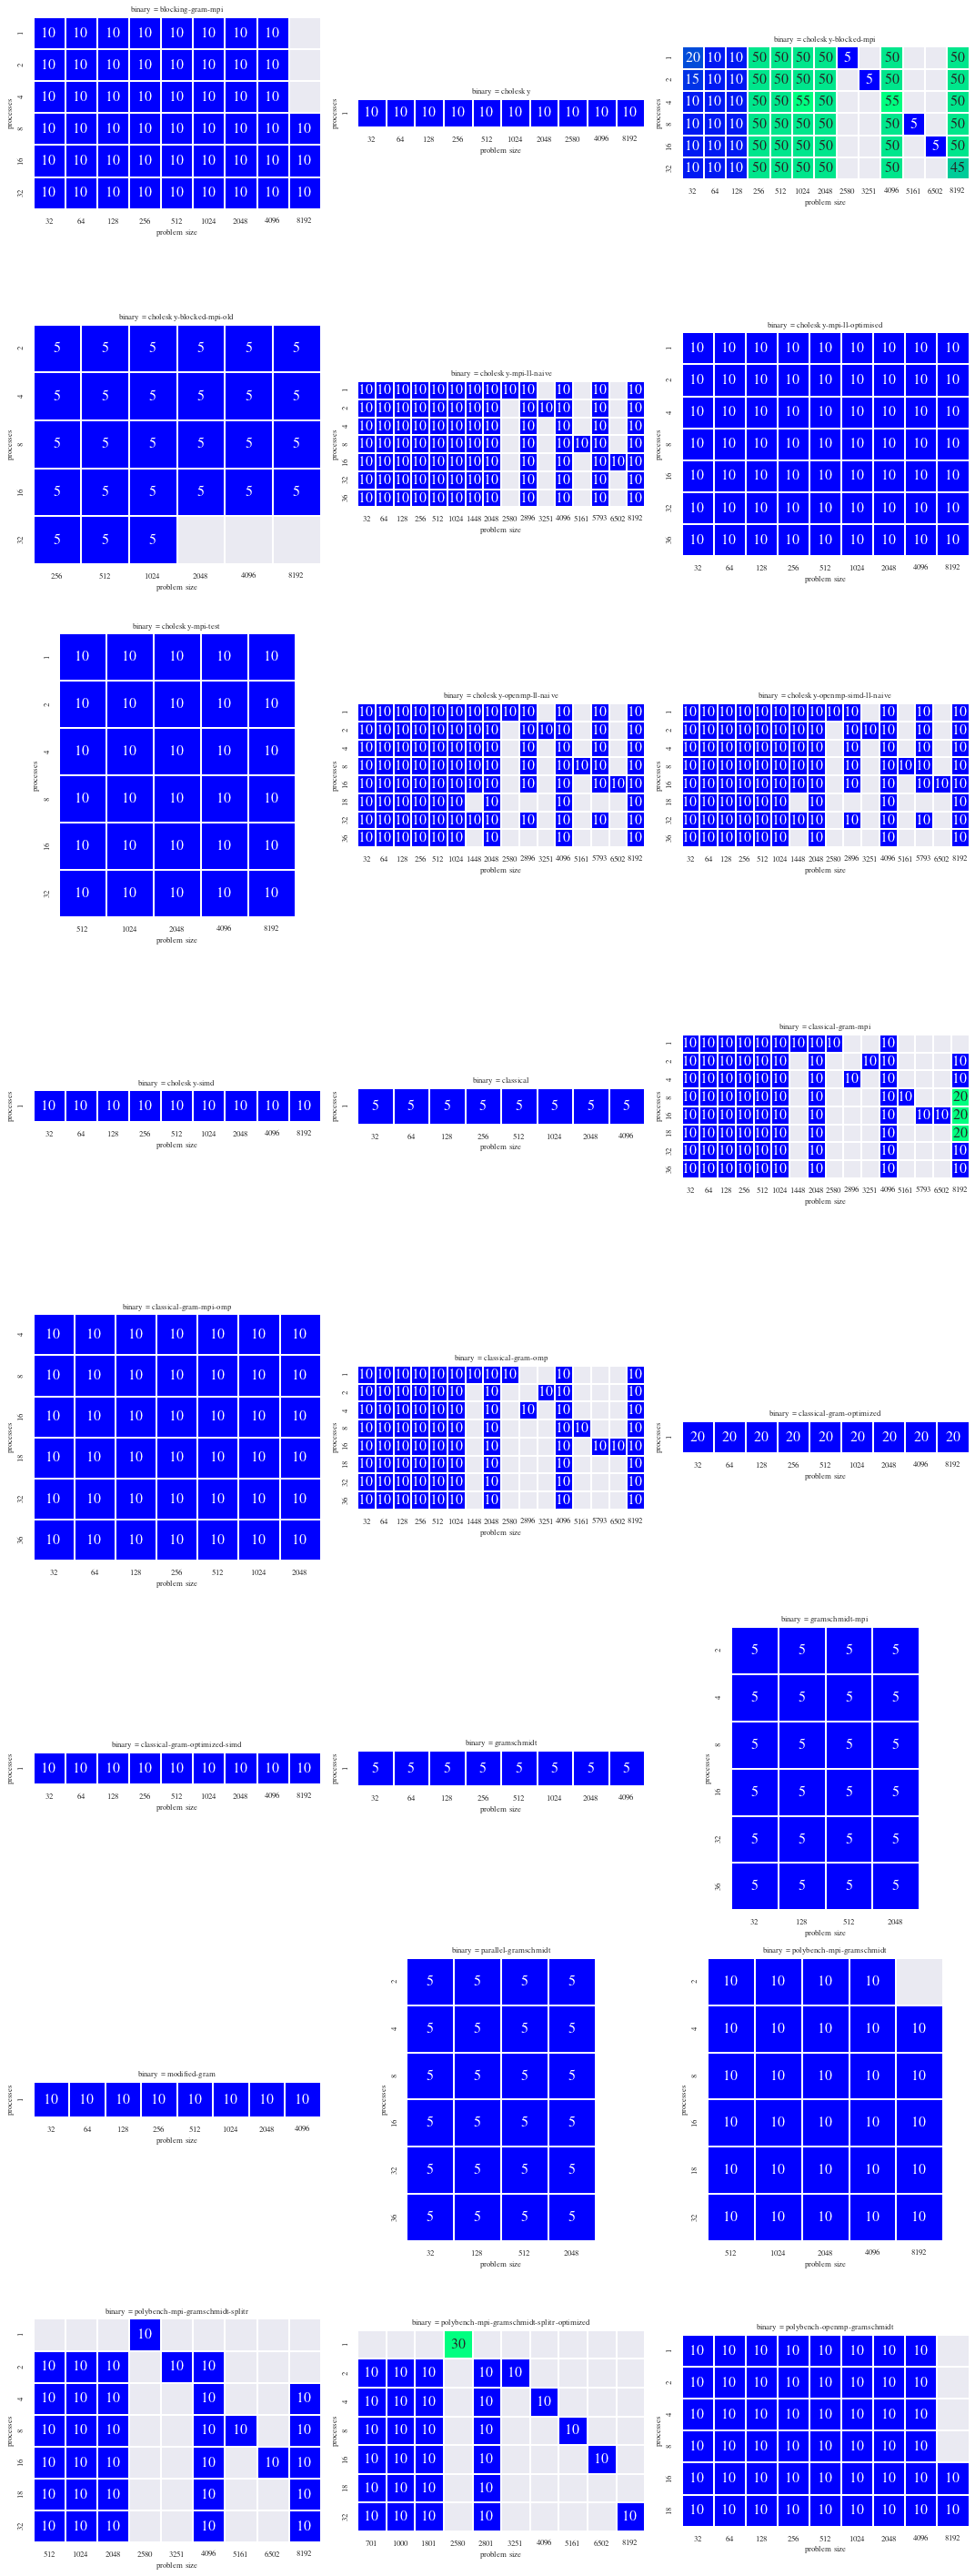

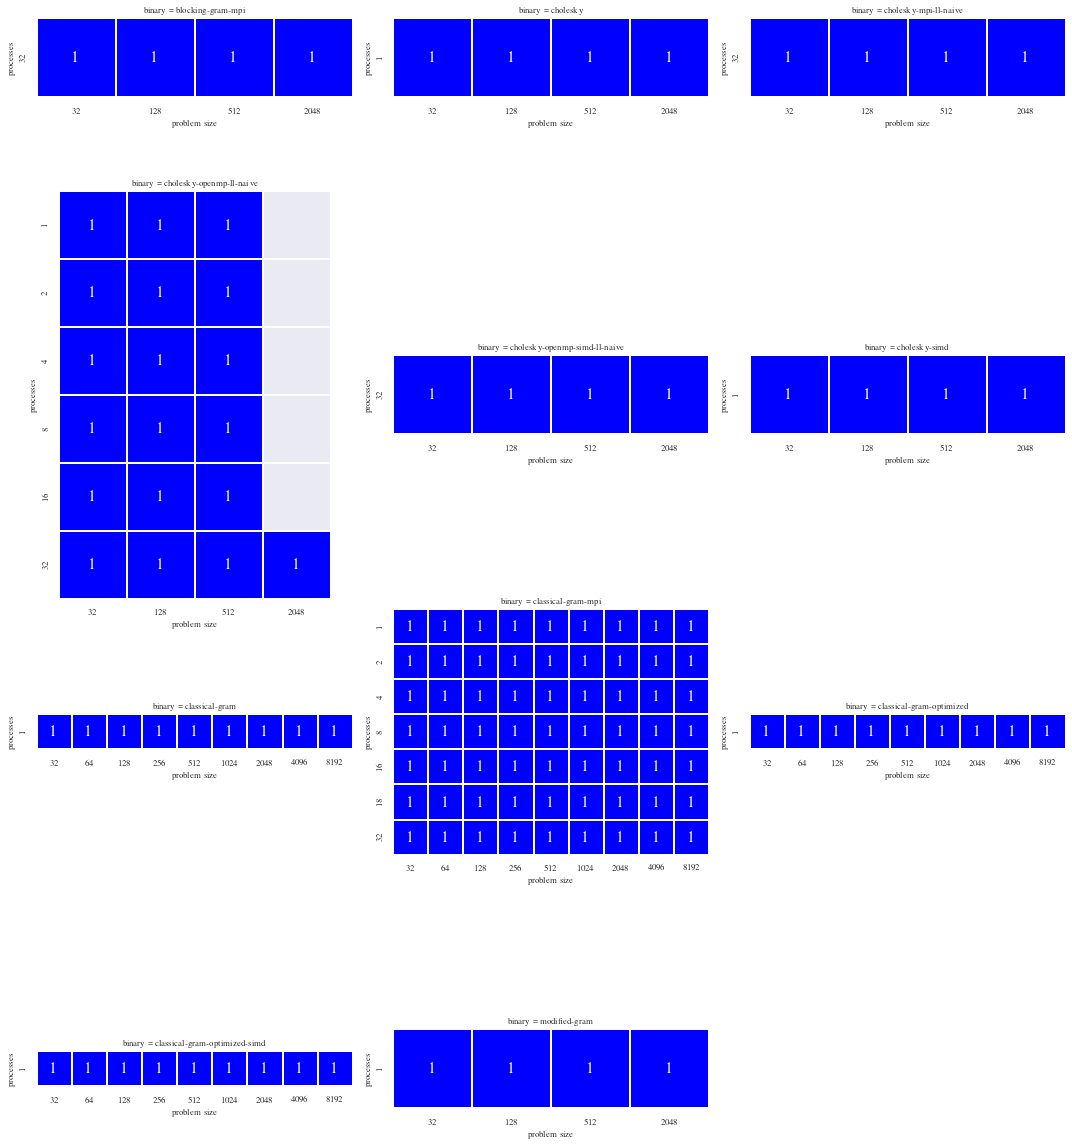

In [15]:
# This creates a plot that shows the number of runs for a given tuple (binary, processes, problem size) 
# For lsb data, each run has an id. For cg, there is only one run per file

# Each binary will be displayed as a facet in a grid
def facet(data, color):
    coverage = data.pivot(index="p", columns="problem size", values="count")
    f = sns.heatmap(coverage, cmap='winter', annot=True, cbar=False, square=True, linewidth=2, linecolor="w", annot_kws={"fontsize":16})
    f.set_ylabel("processes")


lsbdata = libscibenchdata.copy()
cgdata = cachegrinddata.copy()
cgdata["id"] = 1

# Create graph for lsb and gc
for type, data in (("lsb", lsbdata), ("cg", cgdata)):

    # Merge with respective dataset
    coverage_data = pd.merge(experiments, data, on="datafile")

    # # Filter down to binaries of interest
    # coverage_data = coverage_data[coverage_data["binary"].isin(ORDER)]

    # Select required columns
    coverage_data = coverage_data[["binary", "date", "p", "d", "id"]]

    # Select required columns
    coverage_data = coverage_data.drop_duplicates()

    # Calculate problem size
    coverage_data["problem size"] = np.where(coverage_data["d"] > 20, coverage_data["d"], 2**coverage_data["d"])

    # Count number of distinct ids = number of runs
    coverage_data = coverage_data.groupby(["binary", "p", "problem size"])["id"].count().reset_index(name="count")

    g = sns.FacetGrid(coverage_data, col="binary", height=5, legend_out=True, sharex=False, sharey=False, col_wrap=3)
    g = g.map_dataframe(facet)
    g.figure.savefig(f"{OUTPUT_FOLDER}/{type}_coverage.png")


### Runtime vs. input size

In [16]:
X_AXIS = "size"
Y_AXIS = "time"
Z_AXIS = "p"

# Get lsb data for experiment
runtime_data = pd.merge(experiments, libscibenchdata, on="datafile")

# Select required columns
runtime_data = runtime_data[["binary", "p", "size", "id", "rank", "time"]]

# Group data such that we take the max(time) over all ranks (nodes)
runtime_data = runtime_data.groupby(["binary", "size", "p", "id"], as_index=False)["time"].max().reset_index(drop=True)

# Filter sizes to display
runtime_data = runtime_data[runtime_data["size"] >= 1024]

# Create one graph for each binary
for label, data in runtime_data.groupby("binary"):

    # Colors
    n_colors = len(data[Z_AXIS].unique())
    palette=sns.color_palette(COLOR_PALETTE, n_colors)

    # New figure
    plt.figure(figsize=FIGURE_SIZE, constrained_layout=True)
    f = sns.lineplot(data=data, x=X_AXIS, y=Y_AXIS, hue=Z_AXIS, ci='sd', err_style = "bars", err_kws=ERROR_STYLE, marker='o', palette=palette)

    # Labeling
    plt.title(r"\textbf{" +  DISPLAY_NAME_MAPPING.get(label, "other") + r"}" "\n" r"Runtime [$\mu$s] vs. input size", y=TITLE_Y_OFFSET, loc='left')
    f.set_xlabel("")
    f.set_xticks(np.power(2, np.arange(10, 14)))
    f.set_ylabel("")

    # Legend
    f.legend(title=r'cores', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, handlelength=0.5)
    
    # Save plot
    print(f"Export runtime-per-size-{label}")

    export_to = Path(f"{OUTPUT_FOLDER}/runtime-per-size/")
    export_to.mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{export_to.resolve()}/runtime-per-size-{label}.png", bbox_inches='tight')
    plt.savefig(f"{export_to.resolve()}/runtime-per-size-{label}.eps", bbox_inches='tight')

    plt.close()

Export runtime-per-size-blocking-gram-mpi
Export runtime-per-size-cholesky
Export runtime-per-size-cholesky-blocked-mpi
Export runtime-per-size-cholesky-blocked-mpi-old
Export runtime-per-size-cholesky-mpi-ll-naive
Export runtime-per-size-cholesky-mpi-ll-optimised
Export runtime-per-size-cholesky-mpi-test
Export runtime-per-size-cholesky-openmp-ll-naive
Export runtime-per-size-cholesky-openmp-simd-ll-naive
Export runtime-per-size-cholesky-simd
Export runtime-per-size-classical
Export runtime-per-size-classical-gram-mpi
Export runtime-per-size-classical-gram-mpi-omp
Export runtime-per-size-classical-gram-omp
Export runtime-per-size-classical-gram-optimized
Export runtime-per-size-classical-gram-optimized-simd
Export runtime-per-size-gramschmidt
Export runtime-per-size-gramschmidt-mpi
Export runtime-per-size-modified-gram
Export runtime-per-size-parallel-gramschmidt
Export runtime-per-size-polybench-mpi-gramschmidt
Export runtime-per-size-polybench-mpi-gramschmidt-splitr
Export runtime-p

### Runtime vs. number of processors

In [17]:
X_AXIS = "p"
Y_AXIS = "time"
Z_AXIS = "size"

# Get lsb data for experiment
runtime_data = pd.merge(experiments, libscibenchdata, on="datafile")

# Select required columns
runtime_data = runtime_data[["binary", "p", "size", "id", "rank", "time"]]

# Group data such that we take the max(time) over all ranks (nodes)
runtime_data = runtime_data.groupby(["binary", "size", "p", "id"], as_index=False)["time"].max().reset_index(drop=True)

# Filter sizes to display
runtime_data = runtime_data[runtime_data["size"] >= 1024]

# Create one graph for each binary
for label, data in runtime_data.groupby("binary"):

    # Colors
    n_colors = len(data[Z_AXIS].unique())
    palette=sns.color_palette(COLOR_PALETTE, n_colors)

    # New figure
    plt.figure(figsize=FIGURE_SIZE, constrained_layout=True)

    f = sns.lineplot(data=data, x=X_AXIS, y=Y_AXIS, hue=Z_AXIS, ci='sd', err_style = "bars", err_kws=ERROR_STYLE, marker='o', palette=palette)

    # Labeling
    plt.title(r"\textbf{" + DISPLAY_NAME_MAPPING.get(label, "other") + r"}" "\n" r"Runtime [$\mu$s] vs. number of cores", y=TITLE_Y_OFFSET, loc='left')
    f.set_xlabel("")
    f.set_xticks(np.power(2, np.arange(0, 6)))
    f.set_ylabel("")

    # Legend
    f.legend(title=r'input size', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, handlelength=0.5)
    
    # Save plot
    print(f"Export runtime-per-processes-{label}")

    export_to = Path(f"{OUTPUT_FOLDER}/runtime-per-processes/")
    export_to.mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{export_to.resolve()}/runtime-per-processes-{label}.png", bbox_inches='tight')
    plt.savefig(f"{export_to.resolve()}/runtime-per-processes-{label}.eps", bbox_inches='tight')

    plt.close()

Export runtime-per-processes-blocking-gram-mpi
Export runtime-per-processes-cholesky
Export runtime-per-processes-cholesky-blocked-mpi
Export runtime-per-processes-cholesky-blocked-mpi-old
Export runtime-per-processes-cholesky-mpi-ll-naive
Export runtime-per-processes-cholesky-mpi-ll-optimised
Export runtime-per-processes-cholesky-mpi-test
Export runtime-per-processes-cholesky-openmp-ll-naive
Export runtime-per-processes-cholesky-openmp-simd-ll-naive
Export runtime-per-processes-cholesky-simd
Export runtime-per-processes-classical
Export runtime-per-processes-classical-gram-mpi
Export runtime-per-processes-classical-gram-mpi-omp
Export runtime-per-processes-classical-gram-omp
Export runtime-per-processes-classical-gram-optimized
Export runtime-per-processes-classical-gram-optimized-simd
Export runtime-per-processes-gramschmidt
Export runtime-per-processes-gramschmidt-mpi
Export runtime-per-processes-modified-gram
Export runtime-per-processes-parallel-gramschmidt
Export runtime-per-proc

### Speedup to look at

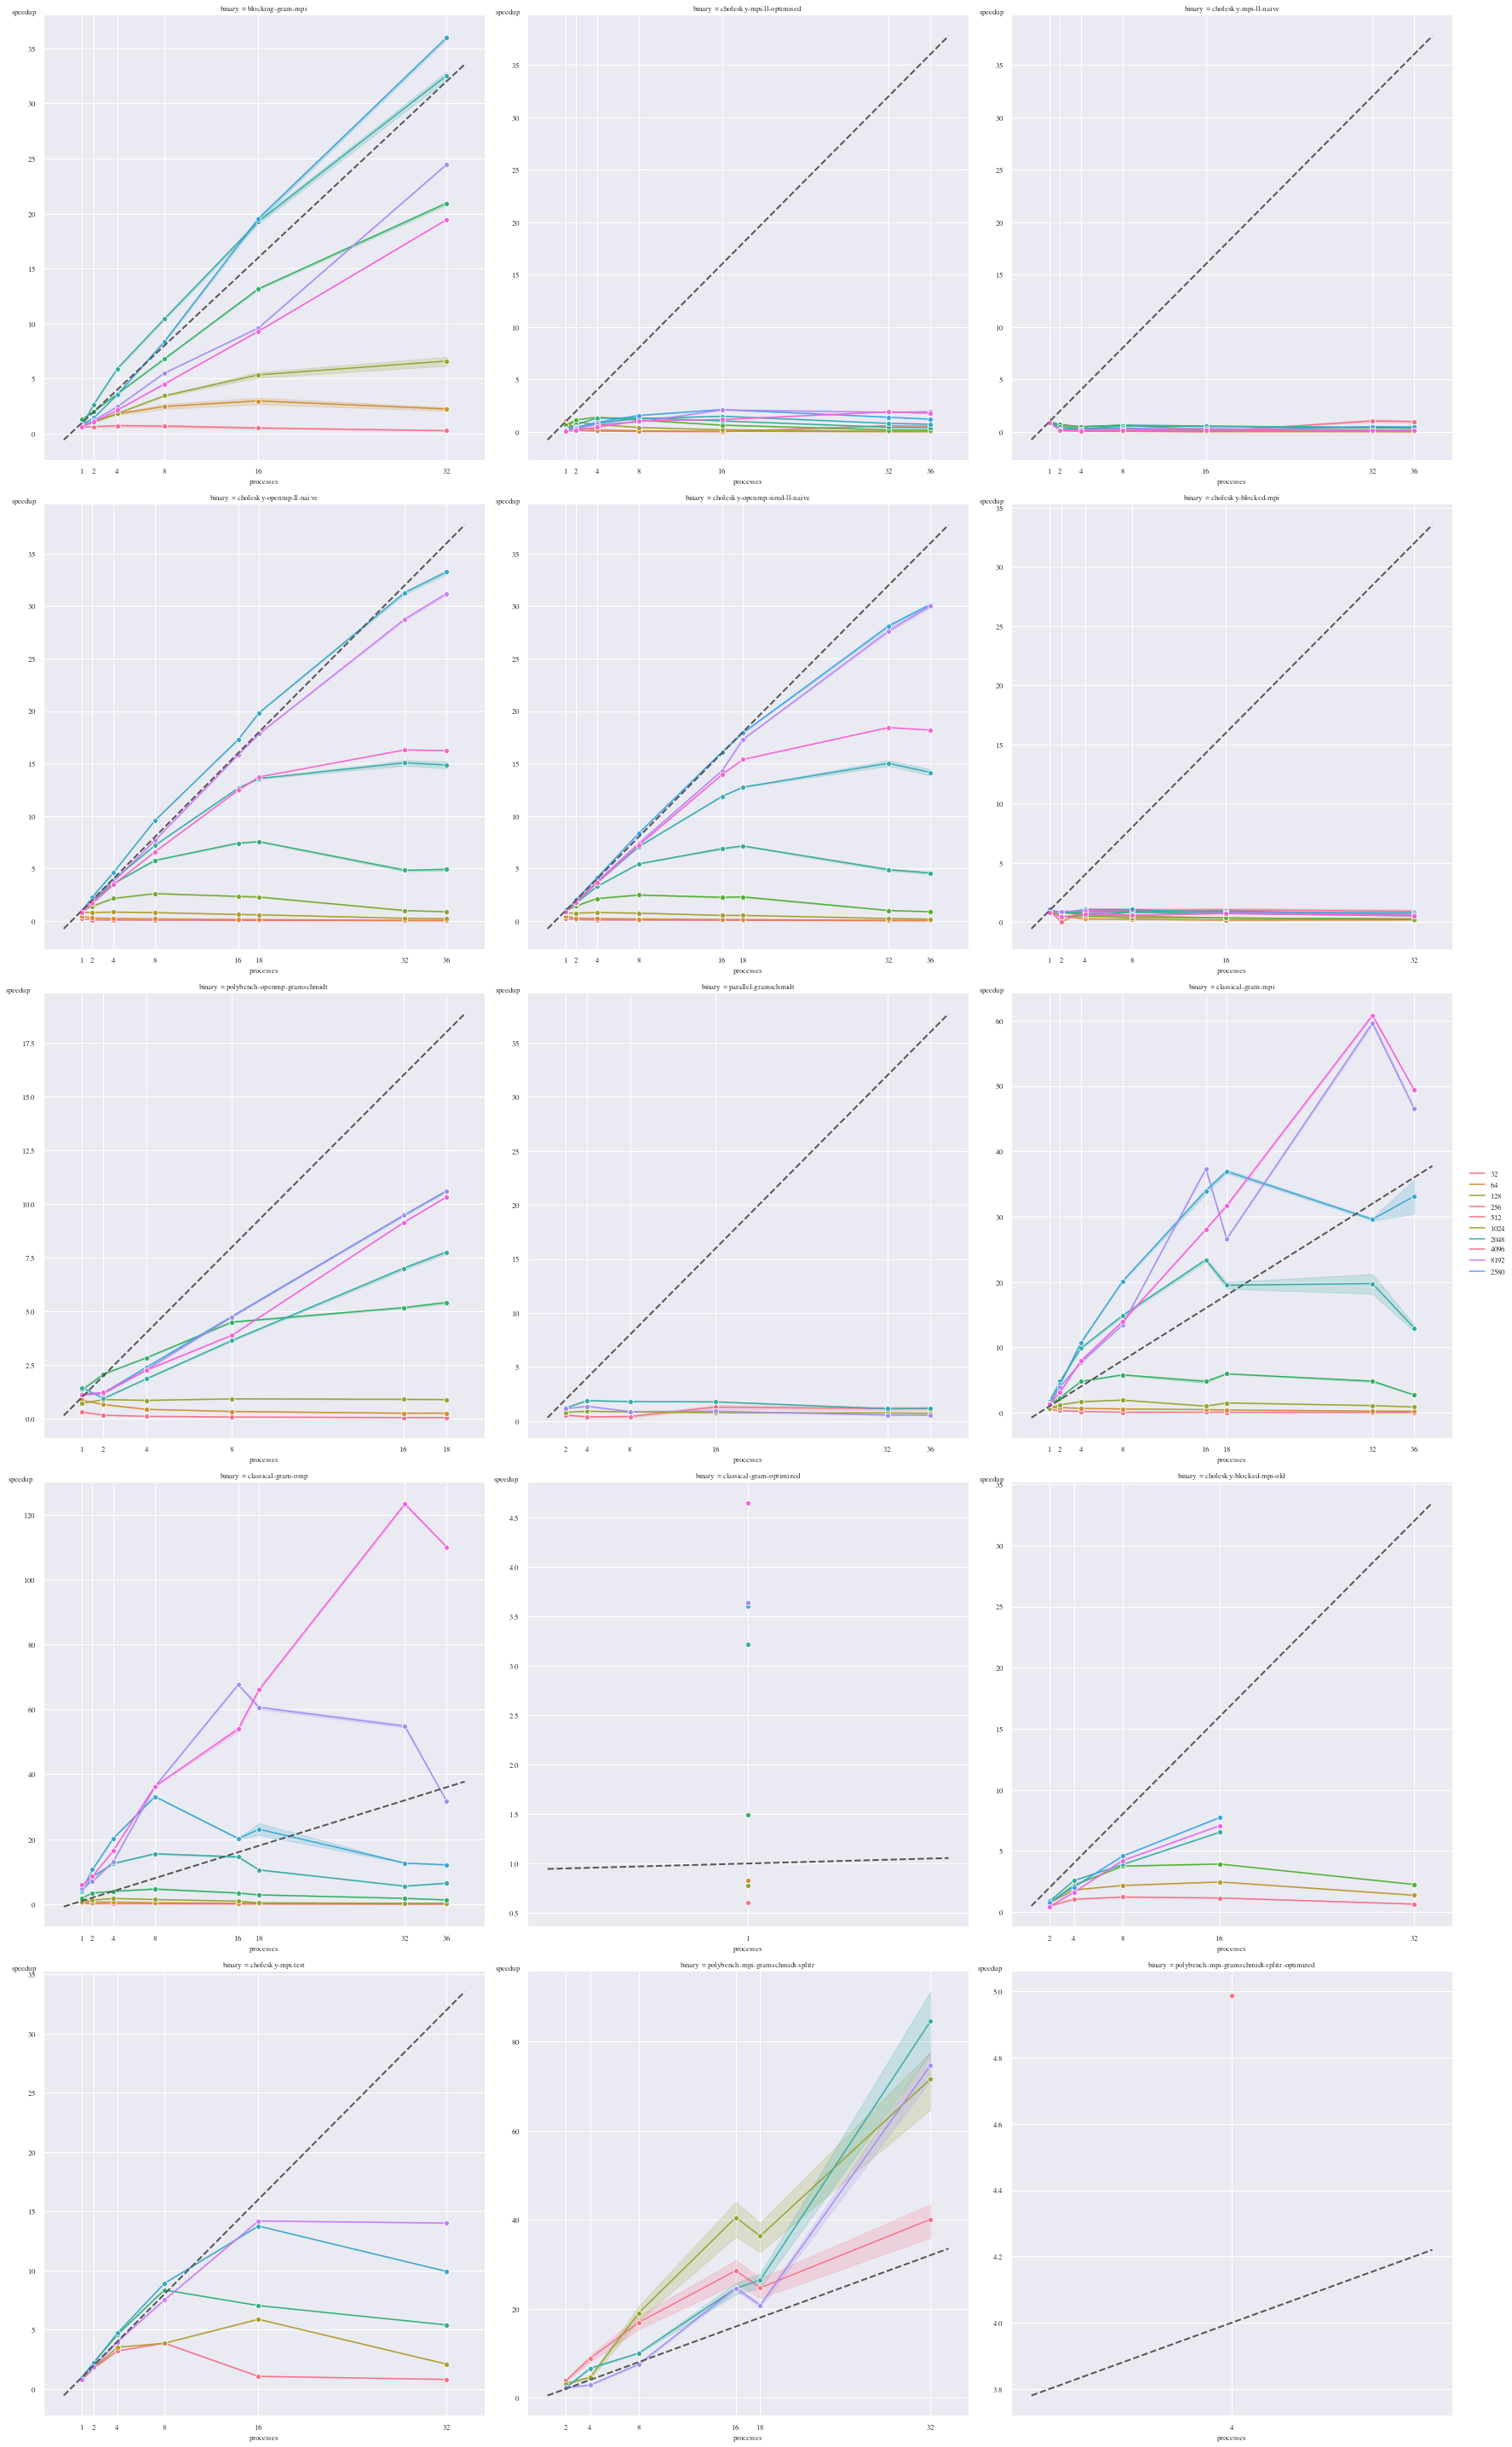

In [18]:
# Get lsb data for experiment
speedup_data = pd.merge(experiments, libscibenchdata, on="datafile")

# Filter down to binaries of interest
# speedup_data = speedup_data[speedup_data["binary"].isin(ORDER)]

# Select required columns
speedup_data = speedup_data[["binary", "p", "size", "id", "rank", "time"]]

# Group over data such that we take the maximum of the runtime with respect to id and rank
speedup_data1 = speedup_data.groupby(["binary", "size", "p", "id"], as_index=False)["time"].max()

# Lookup baseline binary for each binary
speedup_data1["baseline_binary"] = speedup_data1["binary"].map(BASELINE_MAPPING)

speedup_data_seq_mask = speedup_data1["p"] == 1
speedup_data_seq = speedup_data1[["binary", "size", "p", "time"]]
speedup_data_seq = speedup_data_seq[speedup_data_seq_mask]

# Join dataframe with itself such that we get the runtime of the baseline and the runtime of the parallel version 
# for a given number of processes and problem size side by side
speedup_data1 = pd.merge(speedup_data1[["binary", "size", "p", "id", "time", "baseline_binary"]]
    , speedup_data_seq
    , how='inner', left_on=['size','baseline_binary'], right_on = ['size','binary'], suffixes=["", "_seq"])

# Calculate the speedup compared to the baseline
speedup_data1["speedup"] = speedup_data1["time_seq"] / speedup_data1["time"]

speedup_data1 = speedup_data1.sort_values(by="size")

# Define facet to be printed for each binary
def facet(data, color):
    
    # Determine number of series -> number of colors required
    n_colors = len(data["size"].unique())

    # Plot speedup without standard deviation
    f = sns.lineplot(data=data, x="p", y="speedup", hue="size", marker='o', palette=sns.color_palette(COLOR_PALETTE, n_colors))
    f.set_xlabel("processes")
    f.set_xticks(data["p"].unique())
    f.set_ylabel("speedup", rotation=0, y=1, ha='center')
    
    # f.set(xlim=(0, SPEEDUP_Y_MAX))
    # y_max = SPEEDUP_Y_MAX
    # y_max = 5
    # if data["binary"].values[1] in "polybench-openmp-gramschmidt" or data["binary"].values[1] in "classical-gram-mpi":
    #     y_max = data["speedup"].max()+2
    # f.set(ylim=(-0.5, y_max))

    # Alex said no log plot
    # f.set(xscale="log", yscale="log")
    # f.set(ylim=(10**-2, 10**1.5)) 
    # f.set(xlim=(10**0.1, 10**1.8)) 
    # locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    # f.get_xaxis().set_minor_locator(locmin)
    # plt.grid(True,which="both")

    # Draw linear speedup reference
    plt.plot(f.get_xlim(), f.get_xlim(), linewidth=2, color='#555555', linestyle='--')

# Draw speedup graph for each binary
g = sns.FacetGrid(speedup_data1, col="binary", height=8, sharex=False, sharey=False, col_wrap=3)
g = g.map_dataframe(facet)
g.add_legend()

# g.figure.savefig(f"{OUTPUT_FOLDER}/{PREFIX}_speedup_per_process.png")
# g.figure.savefig(f"{OUTPUT_FOLDER}/{PREFIX}_speedup_per_process.eps")
# g.figure.savefig(f"./plots/{PREFIX}_speedup_per_process.svg")



### Speedup

In [19]:
X_AXIS = "p"
Y_AXIS = "speedup"
Z_AXIS = "size"

# Get lsb data for experiment
speedup_data = pd.merge(experiments, libscibenchdata, on="datafile")

# Filter down sizes of interest
speedup_data = speedup_data[speedup_data["size"] >= 256]

# Select required columns
speedup_data = speedup_data[["binary", "p", "size", "id", "rank", "time"]]

# Group over data such that we take the maximum of the runtime with respect to id and rank
speedup_data = speedup_data.groupby(["binary", "size", "p", "id"], as_index=False)["time"].max().reset_index(drop=True)

# Lookup baseline binary for each binary
speedup_data["baseline_binary"] = speedup_data["binary"].map(BASELINE_MAPPING)

speedup_data_seq_mask = speedup_data["p"] == 1
speedup_data_seq = speedup_data[["binary", "size", "p", "time"]]
speedup_data_seq = speedup_data_seq[speedup_data_seq_mask]

# Join dataframe with itself such that we get the runtime of the baseline and the runtime of the parallel version 
# for a given number of processes and problem size side by side
speedup_data = pd.merge(speedup_data[["binary", "size", "p", "id", "time", "baseline_binary"]]
    , speedup_data_seq
    , how='inner', left_on=['size','baseline_binary'], right_on = ['size','binary'], suffixes=["", "_seq"])

# Calculate the speedup compared to the baseline
speedup_data["speedup"] = speedup_data["time_seq"] / speedup_data["time"]

speedup_data = speedup_data.sort_values(by="size")

# Create one graph for each binary
for label, data in speedup_data.groupby("binary"):
    # Colors
    n_colors = len(data[Z_AXIS].unique())
    palette=sns.color_palette(COLOR_PALETTE, n_colors)

    # New figure
    plt.figure(figsize=FIGURE_SIZE, constrained_layout=True)
    f = sns.lineplot(data=data, x=X_AXIS, y=Y_AXIS, hue=Z_AXIS, ci='sd', err_style = "bars", err_kws=ERROR_STYLE, marker='o', palette=palette)

    # Labeling
    #f.set_title(label)
    plt.title(r"\textbf{" + DISPLAY_NAME_MAPPING.get(label, "other") + r"}" + "\nSpeedup vs. processor count", y=TITLE_Y_OFFSET, loc='left')
    f.set_xlabel("")
    f.set_xticks(data["p"].unique())

    f.set_ylabel("")

    # Draw linear speedup reference
    plt.plot(f.get_xlim(), f.get_xlim(), linewidth=2, color='#555555', linestyle='--')

    # Legend
    f.legend(title='input size $n$', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, handlelength=0.5)

    # Save plot
    print(f"Export speedup-{label}")

    export_to = Path(f"{OUTPUT_FOLDER}/speedup/")
    export_to.mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{export_to.resolve()}/speedup-{label}.png", bbox_inches='tight')
    plt.savefig(f"{export_to.resolve()}/speedup-{label}.eps", bbox_inches='tight')

    plt.close()

Export speedup-blocking-gram-mpi
Export speedup-cholesky-blocked-mpi
Export speedup-cholesky-blocked-mpi-old
Export speedup-cholesky-mpi-ll-naive
Export speedup-cholesky-mpi-ll-optimised
Export speedup-cholesky-mpi-test
Export speedup-cholesky-openmp-ll-naive
Export speedup-cholesky-openmp-simd-ll-naive
Export speedup-classical-gram-mpi
Export speedup-classical-gram-omp
Export speedup-classical-gram-optimized
Export speedup-parallel-gramschmidt
Export speedup-polybench-mpi-gramschmidt-splitr
Export speedup-polybench-mpi-gramschmidt-splitr-optimized
Export speedup-polybench-openmp-gramschmidt


### Roofline

Export roofline-cholesky
Export roofline-gramschmidt


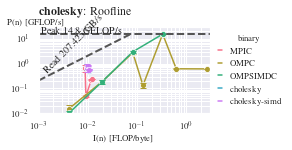

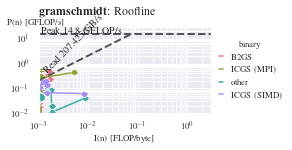

In [20]:
from matplotlib.pyplot import text

X_AXIS = "operational_intensity"
Y_AXIS = "flops_per_cycle"
Z_AXIS = "binary-display-name"

LABELS = ["cholesky", "gramschmidt"]

lsb_data = (experiments
.merge(libscibenchdata, on="datafile")
.merge(cpu_info, on="cpufile")
)

lsb_data = lsb_data.groupby(["binary", "p", "d", "id", "Model name", "CPU max MHz"], as_index=False)["time"].max().reset_index(drop=True)
# lsb_data["size"] = 2**lsb_data["d"]
lsb_data["size"] = np.where(lsb_data["d"] > 20, lsb_data["d"], 2**lsb_data["d"])
lsb_data["flops_per_cycle"] = lsb_data["size"]**3 / (3. * lsb_data["time"] * lsb_data["CPU max MHz"].astype(float, errors = 'raise'))

cg_data = (experiments
.merge(cachegrinddata, on="datafile")
.merge(cpu_info, on="cpufile")
)

cg_data = cg_data.groupby(["binary", "p", "d", "Model name", "CPU max MHz"], as_index=False)[["D1mr", "D1mw"]].sum()
# cg_data["size"] = 2**cg_data["d"]
cg_data["size"] = np.where(cg_data["d"] > 20, cg_data["d"], 2**cg_data["d"])
cg_data["Q"] = (cg_data["D1mr"] + cg_data["D1mw"])*64
cg_data["W"] = cg_data["size"]**3 / 3
cg_data["operational_intensity"] = cg_data["W"] / cg_data["Q"]

roofline_data = pd.merge(lsb_data, cg_data, on=["binary", "p", "size", "Model name", "CPU max MHz"])
# roofline_data = roofline_data[roofline_data["binary"].isin(ORDER)]

# Filter data that we want
roofline_data_temp = roofline_data[(roofline_data["p"] == 1)]
# roofline_data_temp = roofline_data_temp[lambda df: df['binary'] in SEQUENTIAL_ALGOS]
roofline_data_temp.loc[roofline_data_temp["binary"].isin(SEQUENTIAL_ALGOS), :]
roofline_data = roofline_data[(roofline_data["p"] == 32)]
roofline_data = roofline_data.append(roofline_data_temp)

roofline_data["binary-display-name"] = roofline_data["binary"].map(DISPLAY_NAME_MAPPING)
roofline_data["binary-display-name"] = roofline_data["binary-display-name"].fillna("other")

# Create one graph for each binary
for label in LABELS:
    # Filter down to binaries of interest
    if label in "cholesky":
        data = roofline_data[roofline_data["binary"].str.contains(label)]
    else:
        data = roofline_data[~roofline_data["binary"].str.contains("cholesky")] # kinda hacky, I know

    # Colors
    n_colors = len(data[Z_AXIS].unique())
    palette=sns.color_palette(COLOR_PALETTE, n_colors)

    # New figure
    plt.figure(figsize=FIGURE_SIZE, constrained_layout=True)
    f = sns.lineplot(data=data, x=X_AXIS, y=Y_AXIS, hue=Z_AXIS, ci='sd', err_style = "bars", err_kws=ERROR_STYLE, marker='o', palette=palette)

    # Labeling
    #f.set_title(label)
    plt.title(r"\textbf{" + label + r"}: Roofline", y=TITLE_Y_OFFSET, loc='left')
    # f.set_xlabel("")
    # f.set_xticks(data["p"].unique())
    # f.set_ylabel("")

    f.set_xlabel("I(n) [FLOP/byte]")
    f.set_ylabel("P(n) [GFLOP/s]", rotation=0, x=1, y=1, ha='left')

    # Log-log scale
    f.set(xscale="log", yscale="log")
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1),numticks=10)
    f.get_xaxis().set_minor_locator(locmin)
    plt.grid(True,which="both")

    # Resize axes to make square graph
    XMIN, XMAX , YMIN, YMAX = 10**-3, 3, 10**-2, 30
    f.set(xlim=(XMIN, XMAX)) 
    f.set(ylim=(YMIN, YMAX)) 

    # Constants used for reference lines
    cpu_pi = 14.8 
    cpu_beta = 207.425 # GB/s

    # Draw linear speedup reference
    plt.plot((XMIN, XMAX), (cpu_pi, cpu_pi), linewidth=2, color='#555555', linestyle='--')
    text(XMIN * 1.1, cpu_pi*1.1, f"Peak {cpu_pi} GFLOP/s")

    plt.plot((XMIN, cpu_pi / cpu_beta), (XMIN * cpu_beta, cpu_pi) , linewidth=2, color='#555555', linestyle='--')

    angle = 360 / (2*np.pi) * np.arctan( 
        np.log((cpu_pi / cpu_beta) / XMIN) / np.log(cpu_pi / (XMIN * cpu_beta))
        )
    
    text(XMIN * 1.2, XMIN * cpu_beta * 2 , f"Read {cpu_beta} GB/s", rotation = angle)

    # Legend
    f.legend(title='binary', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, handlelength=0.5)

    # Save plot
    print(f"Export roofline-{label}")

    export_to = Path(f"{OUTPUT_FOLDER}/roofline/")
    export_to.mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{export_to.resolve()}/roofline-{label}.png", bbox_inches='tight')
    plt.savefig(f"{export_to.resolve()}/roofline-{label}.eps", bbox_inches='tight')

    #plt.close()

### Weak Scaling

Export weak-scaling-cholesky
Export weak-scaling-gramschmidt


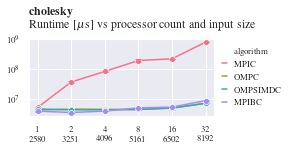

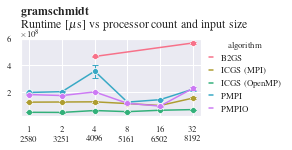

In [44]:
X_AXIS1 = "p"
X_AXIS2 = "size"
Y_AXIS = "time"
Z_AXIS = "binary-display-name"

LABELS = ["cholesky", "gramschmidt"]

BINARY_BLACKLIST = ["cholesky", "cholesky-blocked-mpi-old", "cholesky-mpi-ll-optimised", "cholesky-mpi-test", "polybench-mpi-gramschmidt", "polybench-openmp-gramschmidt"]

# Get lsb data for experiment
weak_scaling_data = pd.merge(experiments, libscibenchdata, on="datafile")

weak_scaling_data["blocksize"] = weak_scaling_data["blocksize"].fillna(value=1)

# Select required columns
weak_scaling_data = weak_scaling_data[["binary", "p", "size", "id", "rank", "time", "blocksize"]]

# Filter out blacklisted binaries
weak_scaling_data = weak_scaling_data[~weak_scaling_data["binary"].isin(BINARY_BLACKLIST)]

# Group over data such that we take the maximum of the runtime with respect to id and rank
weak_scaling_data = weak_scaling_data.groupby(["binary", "size", "p", "id", "blocksize"], as_index=False)["time"].max().reset_index(drop=True)

# Filter data that we want
weak_scaling_data = weak_scaling_data[((weak_scaling_data[X_AXIS2] == 2580) & (weak_scaling_data[X_AXIS1] == 1)) |
                                      ((weak_scaling_data[X_AXIS2] == 3251) & (weak_scaling_data[X_AXIS1] == 2)) |
                                      ((weak_scaling_data[X_AXIS2] == 4096) & (weak_scaling_data[X_AXIS1] == 4)) |
                                      ((weak_scaling_data[X_AXIS2] == 5161) & (weak_scaling_data[X_AXIS1] == 8)) |
                                      ((weak_scaling_data[X_AXIS2] == 6502) & (weak_scaling_data[X_AXIS1] == 16))|
                                      ((weak_scaling_data[X_AXIS2] == 8192) & (weak_scaling_data[X_AXIS1] == 32))]

weak_scaling_data_tmp = weak_scaling_data[(weak_scaling_data["binary"] != "cholesky-blocked-mpi") & (weak_scaling_data["blocksize"] == 1)]
weak_scaling_data = weak_scaling_data_tmp.append(weak_scaling_data[(weak_scaling_data["blocksize"] == 64)])


weak_scaling_data["binary-display-name"] = weak_scaling_data["binary"].map(DISPLAY_NAME_MAPPING)
weak_scaling_data["binary-display-name"] = weak_scaling_data["binary-display-name"].fillna("other")

#print(weak_scaling_data)

# Create one graph for each binary
for label in LABELS:
    # Filter down to binaries of interest
    if label in "cholesky":
        data = weak_scaling_data[weak_scaling_data["binary"].str.contains(label)]
    else:
        data = weak_scaling_data[~weak_scaling_data["binary"].str.contains("cholesky")] # kinda hacky, I know

    # Colors
    n_colors = len(data[Z_AXIS].unique())
    palette=sns.color_palette(COLOR_PALETTE, n_colors)

    # New figure
    plt.figure(figsize=FIGURE_SIZE, constrained_layout=True)
    p = sns.lineplot(data=data, x=X_AXIS1, y=Y_AXIS, hue=Z_AXIS, ci='sd', err_style = "bars", err_kws=ERROR_STYLE, marker='o', palette=palette)

    # Set labels
    plt.title(r"\textbf{" + label + r"}" + "\n" + r"Runtime [$\mu$s] vs processor count and input size", y=TITLE_Y_OFFSET, loc='left')
    p.set_xlabel("")
    p.set_xscale('log', base=2)
    if label in "cholesky":
        p.set_yscale('log')
    else:
        pass
    p.set_xticks(data[X_AXIS1].unique())
    xlabels = zip(data[X_AXIS1].unique(), data[X_AXIS2].unique())

    # Ugly hack so we get x labels in latex format
    xlabels_str = []
    for nproc, dim in xlabels:
        #xlabels_str.append(r"$(" + str(nproc) + ", " + str(dim) + r")$")
        xlabels_str.append(str(nproc) + "\n" + str(dim))
    p.set_xticklabels(xlabels_str)
    p.set_ylabel("")

    # Legend
    p.legend(title='algorithm', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, handlelength=0.5)

    # Save plot
    print(f"Export weak-scaling-{label}")

    export_to = Path(f"{OUTPUT_FOLDER}/weak-scaling/")
    export_to.mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{export_to.resolve()}/weak-scaling-{label}.png", bbox_inches='tight')
    plt.savefig(f"{export_to.resolve()}/weak-scaling-{label}.eps", bbox_inches='tight')

    # plt.close()

### Efficiency

Export efficiency-cholesky
Export efficiency-gramschmidt


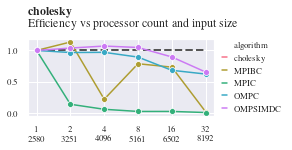

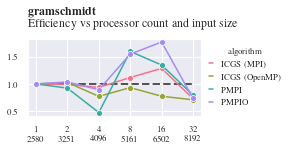

In [22]:
X_AXIS1 = "p"
X_AXIS2 = "size"
Y_AXIS = "efficiency"
Z_AXIS = "binary-display-name"

LABELS = ["cholesky", "gramschmidt"]

# Get lsb data for experiment
efficiency_data = pd.merge(experiments, libscibenchdata, on="datafile")


#efficiency_data["blocksize"] = efficiency_data["blocksize"].fillna(value=1)


# Select required columns
efficiency_data = efficiency_data[["binary", "p", "size", "id", "rank", "time"]]

# Group over data such that we take the maximum of the runtime with respect to id and rank
efficiency_data = efficiency_data.groupby(["binary", "size", "p"], as_index=False)["time"].max().reset_index(drop=True)

# Join dataframe with itself such that we get the runtime of the baseline and the runtime of the parallel version 
# for a given number of processes and problem size side by side
efficiency_data_seq = efficiency_data.loc[efficiency_data[X_AXIS1] == 1]
#efficiency_data_seq = efficiency_data_seq.loc[efficiency_data_seq[X_AXIS2] == 256]
efficiency_data_seq = efficiency_data_seq.loc[efficiency_data_seq[X_AXIS2] == 2580]

efficiency_data = pd.merge(efficiency_data[["binary", "size", "p", "time"]]
    , efficiency_data_seq[["binary", "size", "p", "time"]]
    , how='inner', left_on=['binary'], right_on = ['binary'], suffixes=["", "_seq"])

# Calculate the efficiency scaled with the factor of between the increase in p and increase in work
#efficiency_data.loc[efficiency_data.p != 1, "time"] /= 4
efficiency_data["efficiency"] = efficiency_data["time_seq"] / efficiency_data["time"]

# Filter data that we want
efficiency_data = efficiency_data[((efficiency_data[X_AXIS2] == 2580) & (efficiency_data[X_AXIS1] == 1)) |
                                      ((efficiency_data[X_AXIS2] == 3251) & (efficiency_data[X_AXIS1] == 2)) |
                                      ((efficiency_data[X_AXIS2] == 4096) & (efficiency_data[X_AXIS1] == 4)) |
                                      ((efficiency_data[X_AXIS2] == 5161) & (efficiency_data[X_AXIS1] == 8)) |
                                      ((efficiency_data[X_AXIS2] == 6502) & (efficiency_data[X_AXIS1] == 16))|
                                      ((efficiency_data[X_AXIS2] == 8192) & (efficiency_data[X_AXIS1] == 32))]

efficiency_data["binary-display-name"] = efficiency_data["binary"].map(DISPLAY_NAME_MAPPING)
efficiency_data["binary-display-name"] = efficiency_data["binary-display-name"].fillna("other")

# Create one graph for each binary
for label in LABELS:
    # Filter down to binaries of interest
    if label in "cholesky":
        data = efficiency_data[efficiency_data["binary"].str.contains(label)]
    else:
        data = efficiency_data[~efficiency_data["binary"].str.contains("cholesky")] # kinda hacky, I know

    # Colors
    n_colors = len(data[Z_AXIS].unique())
    palette=sns.color_palette(COLOR_PALETTE, n_colors)

    # New figure
    plt.figure(figsize=FIGURE_SIZE, constrained_layout=True)

    # Draw reference line
    plt.plot([1,32], [1,1], linewidth=2, color='#555555', linestyle='--')

    # Plot data
    p = sns.lineplot(data=data, x=X_AXIS1, y=Y_AXIS, hue=Z_AXIS, ci='sd', err_style = "bars", err_kws=ERROR_STYLE, marker='o', palette=palette)

    # Set labels
    plt.title(r"\textbf{" + label + r"}" "\n" + r"Efficiency vs processor count and input size", y=TITLE_Y_OFFSET, loc='left')
    p.set_xlabel("")
    p.set_xscale('log', base=2)
    p.set_xticks(data[X_AXIS1].unique())
    xlabels = zip(data[X_AXIS1].unique(), data[X_AXIS2].unique())

    # Ugly hack so we get x labels in latex format
    xlabels_str = []
    for nproc, dim in xlabels:
        #xlabels_str.append(r"$(" + str(nproc) + ", " + str(dim) + r")$")
        xlabels_str.append(str(nproc) + "\n" + str(dim))
    p.set_xticklabels(xlabels_str)
    p.set_ylabel("")

    
    # Legend
    p.legend(title='algorithm', loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, handlelength=0.5)

    # Save plot
    print(f"Export efficiency-{label}")

    export_to = Path(f"{OUTPUT_FOLDER}/efficiency/")
    export_to.mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{export_to.resolve()}/efficiency-{label}.png", bbox_inches='tight')
    plt.savefig(f"{export_to.resolve()}/efficiency-{label}.eps", bbox_inches='tight')

    # plt.close()

### Block Size

In [23]:
SPLIT = "p"
X_AXIS = "blocksize"
Y_AXIS = "speedup"
Z_AXIS = "size"

# Get lsb data for experiment
speedup_data = pd.merge(experiments, libscibenchdata, on="datafile")

speedup_data["blocksize"] = speedup_data["blocksize"].fillna(value=1)

# Select required columns
speedup_data = speedup_data[["binary", "p", "size", "id", "rank", "time", "blocksize"]]

# Group over data such that we take the maximum of the runtime with respect to id and rank
speedup_data = speedup_data.groupby(["binary", "size", "p", "id", "blocksize"], as_index=False)["time"].max().reset_index(drop=True)

# Lookup baseline binary for each binary
speedup_data["baseline_binary"] = speedup_data["binary"].map(BASELINE_MAPPING)

speedup_data_seq_mask = speedup_data["p"] == 1
speedup_data_seq = speedup_data[["binary", "size", "p", "time"]]
speedup_data_seq = speedup_data_seq[speedup_data_seq_mask]

# Join dataframe with itself such that we get the runtime of the baseline and the runtime of the parallel version 
# for a given number of processes and problem size side by side
speedup_data = pd.merge(speedup_data[["binary", "size", "p", "time", "baseline_binary", "blocksize"]]
    , speedup_data_seq
    , how='inner', left_on=['size','baseline_binary'], right_on = ['size','binary'], suffixes=["", "_seq"])

# Calculate the speedup compared to the baseline
speedup_data["speedup"] = speedup_data["time_seq"] / speedup_data["time"]

# Filter down to binaries of interest
speedup_data = speedup_data[speedup_data["binary"].isin(["cholesky-blocked-mpi"])]
speedup_data = speedup_data[(speedup_data["size"] >= 256) & (speedup_data["size"] <= 8192)]
speedup_data = speedup_data.sort_values(by="size")

# Create one graph for each binary
for label, data in speedup_data.groupby(SPLIT):
    # Colors
    n_colors = len(data[Z_AXIS].unique())
    palette=sns.color_palette(COLOR_PALETTE, n_colors)

    # New figure
    plt.figure(figsize=FIGURE_SIZE, constrained_layout=True)
    f = sns.lineplot(data=data, x=X_AXIS, y=Y_AXIS, hue=Z_AXIS, ci='sd', err_style = "bars", err_kws=ERROR_STYLE, marker='o', palette=palette)

    # Labeling
    plt.title(r"\textbf{" + DISPLAY_NAME_MAPPING["cholesky-blocked-mpi"] + " on " + str(label) + r" cores}" + "\nSpeedup vs. block size", y=TITLE_Y_OFFSET, loc='left')
    f.set_xlabel("")
    f.set_xscale('log', base=2)
    f.set_xticks(data[X_AXIS].unique())
    f.set_xticklabels(data[X_AXIS].astype(int).unique())

    f.set_ylabel("")

    # Legend
    f.legend(title="input size", loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, handlelength=0.5)

    # Save plot
    print(f"Export speedup-cores-{label}")

    export_to = Path(f"{OUTPUT_FOLDER}/blocksize/")
    export_to.mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{export_to.resolve()}/speedup-cores-{label}.png", bbox_inches='tight')
    plt.savefig(f"{export_to.resolve()}/speedup-cores-{label}.eps", bbox_inches='tight')

    plt.close()

Export speedup-cores-1
Export speedup-cores-2
Export speedup-cores-4
Export speedup-cores-8
Export speedup-cores-16
Export speedup-cores-32


In [24]:
SPLIT = "size"
X_AXIS = "blocksize"
Y_AXIS = "speedup"
Z_AXIS = "p"

# Get lsb data for experiment
speedup_data = pd.merge(experiments, libscibenchdata, on="datafile")

speedup_data["blocksize"] = speedup_data["blocksize"].fillna(value=1)

# Select required columns
speedup_data = speedup_data[["binary", "p", "size", "id", "rank", "time", "blocksize"]]

# Group over data such that we take the maximum of the runtime with respect to id and rank
speedup_data = speedup_data.groupby(["binary", "size", "p", "id", "blocksize"], as_index=False)["time"].max().reset_index(drop=True)

# Lookup baseline binary for each binary
speedup_data["baseline_binary"] = speedup_data["binary"].map(BASELINE_MAPPING)

speedup_data_seq_mask = speedup_data["p"] == 1
speedup_data_seq = speedup_data[["binary", "size", "p", "time"]]
speedup_data_seq = speedup_data_seq[speedup_data_seq_mask]

# Join dataframe with itself such that we get the runtime of the baseline and the runtime of the parallel version 
# for a given number of processes and problem size side by side
speedup_data = pd.merge(speedup_data[["binary", "size", "p", "time", "baseline_binary", "blocksize"]]
    , speedup_data_seq
    , how='inner', left_on=['size','baseline_binary'], right_on = ['size','binary'], suffixes=["", "_seq"])

# Calculate the speedup compared to the baseline
speedup_data["speedup"] = speedup_data["time_seq"] / speedup_data["time"]

# Filter down to binaries of interest
speedup_data = speedup_data[speedup_data["binary"].isin(["cholesky-blocked-mpi"])]

# Pivot by blocksize that has maximum speedup
speedup_data = speedup_data[(speedup_data["size"] >= 256) & (speedup_data["size"] <= 8192)]
speedup_data = speedup_data.sort_values(by="size")

# Create one graph for each binary
for label, data in speedup_data.groupby(SPLIT):
    # Colors
    n_colors = len(data[Z_AXIS].unique())
    palette=sns.color_palette(COLOR_PALETTE, n_colors)

    # New figure
    plt.figure(figsize=(LINE_WIDTH*1.2,LINE_WIDTH*1.2/(4/2)), constrained_layout=True)
    f = sns.lineplot(data=data, x=X_AXIS, y=Y_AXIS, hue=Z_AXIS, ci='sd', err_style = "bars", err_kws=ERROR_STYLE, marker='o', palette=palette)

    # Labeling
    plt.title(r"\textbf{" + DISPLAY_NAME_MAPPING["cholesky-blocked-mpi"] + " with input size " + str(label) + r"}" + "\nSpeedup vs. block size", y=TITLE_Y_OFFSET, loc='left')
    f.set_xlabel("")
    f.set_xscale('log', base=2)
    f.set_xticks(data[X_AXIS].unique())
    f.set_xticklabels(data[X_AXIS].astype(int).unique())

    f.set_ylabel("")

    # Legend
    f.legend(title="processes", loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, handlelength=0.5)

    # Save plot
    print(f"Export speedup-size-{label}")

    export_to = Path(f"{OUTPUT_FOLDER}/blocksize/")
    export_to.mkdir(parents=True, exist_ok=True)
    plt.savefig(f"{export_to.resolve()}/speedup-size-{label}.png", bbox_inches='tight')
    plt.savefig(f"{export_to.resolve()}/speedup-size-{label}.eps", bbox_inches='tight')

    plt.close()

Export speedup-size-256
Export speedup-size-512
Export speedup-size-1024
Export speedup-size-2048
Export speedup-size-2580
Export speedup-size-4096
Export speedup-size-8192


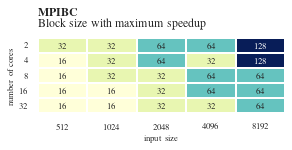

In [25]:
SPLIT = "size"
X_AXIS = "blocksize"
Y_AXIS = "speedup"
Z_AXIS = "p"

# Get lsb data for experiment
speedup_data = pd.merge(experiments, libscibenchdata, on="datafile")

speedup_data["blocksize"] = speedup_data["blocksize"].fillna(value=1)

# Select required columns
speedup_data = speedup_data[["binary", "p", "size", "id", "rank", "time", "blocksize"]]

# Group over data such that we take the maximum of the runtime with respect to id and rank
speedup_data = speedup_data.groupby(["binary", "size", "p", "blocksize"], as_index=False)["time"].max().reset_index(drop=True)

# Lookup baseline binary for each binary
speedup_data["baseline_binary"] = speedup_data["binary"].map(BASELINE_MAPPING)

speedup_data_seq_mask = speedup_data["p"] == 1
speedup_data_seq = speedup_data[["binary", "size", "p", "time"]]
speedup_data_seq = speedup_data_seq[speedup_data_seq_mask]

# Join dataframe with itself such that we get the runtime of the baseline and the runtime of the parallel version 
# for a given number of processes and problem size side by side
speedup_data = pd.merge(speedup_data[["binary", "size", "p", "time", "baseline_binary", "blocksize"]]
    , speedup_data_seq
    , how='inner', left_on=['size','baseline_binary'], right_on = ['size','binary'], suffixes=["", "_seq"])

# Calculate the speedup compared to the baseline
speedup_data["speedup"] = speedup_data["time_seq"] / speedup_data["time"]

# Filter down to binaries of interest
speedup_data = speedup_data[speedup_data["binary"].isin(["cholesky-blocked-mpi"])]
speedup_data = speedup_data[(speedup_data["size"] >= 512) & (speedup_data["p"] >= 2)]

speedup_data = speedup_data.loc[speedup_data.groupby(["size", "p"])["speedup"].idxmax()]
best_block_size = speedup_data.pivot(index="p", columns="size", values="blocksize").astype(int)

n_colors = len(speedup_data["blocksize"].unique())
palette=sns.color_palette(COLOR_PALETTE, n_colors)

plt.figure(figsize=(LINE_WIDTH*1.2,LINE_WIDTH*1.2/(4/2)), constrained_layout=True)
f = sns.heatmap(best_block_size, cmap="YlGnBu", annot=True, cbar=False, linewidth=2, linecolor="w", annot_kws={"fontsize":9}, fmt='g')

plt.title(r"\textbf{" + DISPLAY_NAME_MAPPING["cholesky-blocked-mpi"] + r"}" + "\nBlock size with maximum speedup", y=TITLE_Y_OFFSET, loc='left')
f.set_xlabel("input size")
f.set_ylabel("number of cores")
plt.yticks(rotation=0) 

export_to = Path(f"{OUTPUT_FOLDER}/blocksize/")
export_to.mkdir(parents=True, exist_ok=True)
plt.savefig(f"{export_to.resolve()}/best-block-size.png", bbox_inches='tight')
plt.savefig(f"{export_to.resolve()}/best-block-size.eps", bbox_inches='tight')
